In [1]:
# %autosave 15

In [2]:
!pip install pyreadstat pandas_ta xarray_jax graphviz netcdf4

In [3]:
"""
Simple test for formula loading and evaluation.
"""
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join("/home/ubuntu/projects/hindsight/examples/data/ast", '../../..')))

import matplotlib.pyplot as plt
import jax
import pandas as pd
import pandas_ta as ta
import jax.numpy as jnp

from src import DataManager
from src.data.ast import parse_formula
from src.data.ast.manager import FormulaManager
from src.data.ast.functions import register_built_in_functions, get_function_context
from src.data.core import prepare_for_jit

/home/ubuntu/projects/hindsight/src/data/core/struct.py:282: AccessorRegistrationWarning: registration of accessor <class 'src.data.core.struct.DataArrayDateTimeAccessor'> under name 'dt' for type <class 'xarray.core.dataarray.DataArray'> is overriding a preexisting attribute with the same name.
  @xr.register_dataarray_accessor('dt')


In [4]:
# Register built-in functions
register_built_in_functions()

In [5]:
# Initialize and load formulas
manager = FormulaManager()
# DEPRECATED: manager.load_directory("../../.././src/data/ast/definitions")
# init of formula manager will autoload all defns

In [6]:
# # Load CRSP data
# dm = DataManager()
# ds = dm.get_data(
#     {
#         "data_sources": [
#             {
#                 "data_path": "wrds/equity/crsp",
#                 "config": {
#                     "start_date": "2020-01-01",
#                     "end_date": "2024-01-01",
#                     "freq": "D",
#                     "filters": {
#                         "date__gte": "2020-01-01"
#                     },
#                     "processors": {
#                         "replace_values": {
#                             "source": "delistings",
#                             "rename": [["dlstdt", "time"]],
#                             "identifier": "permno",
#                             "from_var": "dlret",
#                             "to_var": "ret"
#                         },
#                         "merge_table": [
#                             {
#                                 "source": "msenames",
#                                 "identifier": "permno",
#                                 "column": "comnam",
#                                 "axis": "asset"
#                             },
#                             {
#                                 "source": "msenames",
#                                 "identifier": "permno",
#                                 "column": "exchcd",
#                                 "axis": "asset"
#                             }
#                         ],
#                         "set_permco_coord": True,
#                         "fix_market_equity": True
#                     }
#                 }
#             }
#         ]
#     }
# )['wrds/equity/crsp']

wrds/equity/crsp: Level 1 cache not found. Loading data using loader (id: 128731952443472).


/home/ubuntu/projects/hindsight/src/data/core/struct.py:282: AccessorRegistrationWarning: registration of accessor <class 'src.data.core.struct.DataArrayDateTimeAccessor'> under name 'dt' for type <class 'xarray.core.dataarray.DataArray'> is overriding a preexisting attribute with the same name.
  @xr.register_dataarray_accessor('dt')


KeyboardInterrupt: 

In [7]:
ds = dm.load_builtin("equity_standard", "2020-01-01", "2024-01-01")['equity_prices']

wrds/equity/crsp: Attemping to load found cache(/home/suchismit/data/cache/wrds/equity/crsp/7e3864940c40aa33cd39f87339380cb1_2020-01-01_2023-12-31.nc).
wrds/equity/crsp: Successfully loaded from /home/suchismit/data/cache/wrds/equity/crsp/7e3864940c40aa33cd39f87339380cb1_2020-01-01_2023-12-31.nc


In [8]:
# create the closing prices

ds["close"] = ds["prc"] / ds["cfacpr"]

#### Computation & Check

In [9]:
# Prepare data for JIT, since some vars are not JIT compatible. For example, strings.
ds_jit, recover = prepare_for_jit(ds)

ds_jit

<xarray.Dataset> Size: 1GB
Dimensions:       (year: 4, month: 12, day: 31, asset: 11803, time: 1488)
Coordinates:
  * year          (year) int32 16B 2020 2021 2022 2023
  * month         (month) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
  * day           (day) int32 124B 1 2 3 4 5 6 7 8 9 ... 24 25 26 27 28 29 30 31
  * asset         (asset) float64 94kB 1.003e+04 1.003e+04 ... 9.344e+04
    time          (year, month, day) datetime64[ns] 12kB 2020-01-01 ... 2023-...
    mask          (time) bool 1kB False True True False ... True False False
    mask_indices  (time) int64 12kB 1 2 5 6 7 8 9 12 ... -1 -1 -1 -1 -1 -1 -1 -1
    permco        (asset) float32 47kB 7.976e+03 7.978e+03 ... 5.345e+04
Data variables: (12/18)
    issuno        (year, month, day, asset) float32 70MB nan nan nan ... nan nan
    hexcd         (year, month, day, asset) float32 70MB nan nan nan ... nan nan
    hsiccd        (year, month, day, asset) float32 70MB nan nan nan ... nan nan
    bidlo         (year, month, day, asset) float32 70MB nan nan nan ... nan nan
    askhi         (year, month, day, asset) float32 70MB nan nan nan ... nan nan
    prc           (year, month, day, asset) float32 70MB nan nan nan ... nan nan
    ...            ...
    cfacshr       (year, month, day, asset) float32 70MB nan nan nan ... nan nan
    openprc       (year, month, day, asset) float32 70MB nan nan nan ... nan nan
    numtrd        (year, month, day, asset) float32 70MB nan nan nan ... nan nan
    retx          (year, month, day, asset) float32 70MB nan nan nan ... nan nan
    me            (year, month, day, asset) float32 70MB nan nan nan ... nan nan
    close         (year, month, day, asset) float32 70MB nan nan nan ... nan nan

In [10]:
## Uncomment the below line to view the recovery dict (this primarily contains metadata and
## vars that were removed to make the dataset JIT compatible) 

# recover

### RSI

In [11]:
# Actual computation

# Create evaluation context with both data and functions
context = {
    "price": "close",
    "window": 14,
    "_dataset": ds_jit
}
context.update(get_function_context())  # Add all registered functions

# JIT compile the evaluation
# @jax.jit 
def _eval(context):
    result = manager.evaluate("rsi", context)
    return result
    
## ideally this should be JIT compiled but ipy kernel doesn't seem to be happy with it. Ignore for now.

In [12]:
result = _eval(context) # eval w/ the context.

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [13]:
asset_permno = 14593 # APPLE's permno
ds = ds.assign(rsi=result) # Assigning RSI to the original dataset

In [14]:
# All computations and assignments are done. We can now move back to a more manageable format for the ds.

# Select APPLE and the vars we just computed + the closing price.
subset = ds[['rsi', 'close']].sel(asset=asset_permno) 
ts = subset.dt.to_time_indexed() # refer to the docs. (essentially flattens the time dimension)

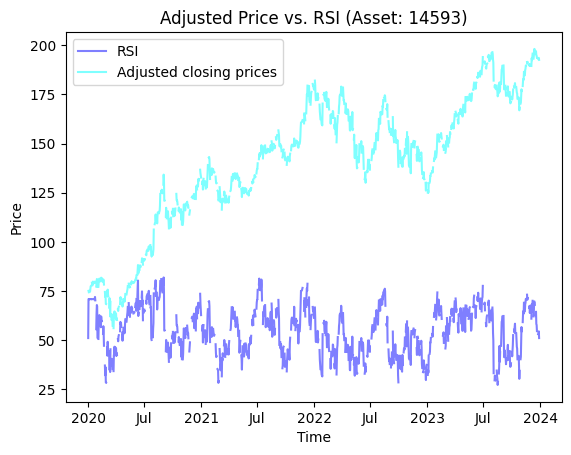

In [15]:
# Since time is now a single flattened dimension, X-array plot functions work happily.
# X-Array does not support multidimensional time plotting, hence ALWAYS flatten before plot (for now)
ts['rsi'].plot.line(x="time", label='RSI', color='blue', alpha=0.5) 
ts['close'].plot.line(x="time", label='Adjusted closing prices', color='cyan', alpha=0.5) 
plt.title(f"Adjusted Price vs. RSI (Asset: {asset_permno})")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(False)

In [16]:
# We will do manual eye-check.

# Get the RSIs and the closing prices from the flattened ds and conver to pandas.
df = ts[['rsi', 'close']].to_dataframe()

df[-20:] # view last 10 records.

,rsi,close,asset,permco
time,,,,
2023-12-12,64.695534,194.710007,14593.0,7.0
2023-12-13,69.489891,197.960007,14593.0,7.0
2023-12-14,69.694443,198.110001,14593.0,7.0
2023-12-15,67.928772,197.570007,14593.0,7.0
2023-12-16,NaN,NaN,14593.0,7.0
2023-12-17,NaN,NaN,14593.0,7.0
2023-12-18,62.613960,195.889999,14593.0,7.0
2023-12-19,64.484291,196.940002,14593.0,7.0
2023-12-20,58.184933,194.830002,14593.0,7.0


In [17]:
# Pandas TA Version

rsi_pd = ta.rsi(df['close'].dropna(), length=14)

rsi_pd[-20:]

time
2023-12-01    67.434918
2023-12-04    60.924548
2023-12-05    68.210429
2023-12-06    64.632519
2023-12-07    67.851840
2023-12-08    70.021930
2023-12-11    62.091476
2023-12-12    64.695535
2023-12-13    69.489891
2023-12-14    69.694440
2023-12-15    67.928779
2023-12-18    62.613965
2023-12-19    64.484296
2023-12-20    58.184936
2023-12-21    57.752983
2023-12-22    54.609715
2023-12-26    53.026884
2023-12-27    53.291939
2023-12-28    54.481471
2023-12-29    51.061838
Name: RSI_14, dtype: float64

### ALMA

In [18]:
# Create evaluation context with both data and functions
context = {
    "price": "close",
    "window": 10,    # Default for ALMA
    "offset": 0.85,  # Default offset
    "sigma": 6.0,    # Default sigma
    "_dataset": ds_jit
}
context.update(get_function_context())

# JIT compile the evaluation
def _eval(context):
    result = manager.evaluate("alma", context)
    return result

result = _eval(context) # eval w/ the context.

asset_permno = 14593 # APPLE's permno
ds = ds.assign(alma=result) 

# Select APPLE and the vars we just computed + the closing price.
subset = ds[['alma', 'close']].sel(asset=asset_permno) 
ts = subset.dt.to_time_indexed() 

/home/ubuntu/conda/envs/jax/lib/python3.12/site-packages/jax/_src/core.py:700: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/home/ubuntu/conda/envs/jax/lib/python3.12/site-packages/jax/_src/core.py:700: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/home/ubuntu/conda/envs/jax/lib/python3.12/site-packages/jax/_src/core.py:700: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


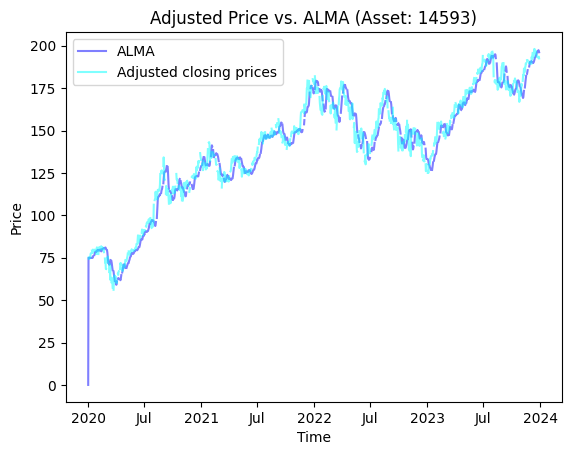

In [19]:
# Since time is now a single flattened dimension, X-array plot functions work happily.
# X-Array does not support multidimensional time plotting, hence ALWAYS flatten before plot (for now)
ts['alma'].plot.line(x="time", label='ALMA', color='blue', alpha=0.5) 
ts['close'].plot.line(x="time", label='Adjusted closing prices', color='cyan', alpha=0.5) 
plt.title(f"Adjusted Price vs. ALMA (Asset: {asset_permno})")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(False)

In [20]:
# We will do manual eye-check.

df = ts[['alma', 'close']].to_dataframe()

df[-20:]['alma'] # view last 10 records.

time
2023-12-12    190.434906
2023-12-13    191.077164
2023-12-14    191.852615
2023-12-15    192.675873
2023-12-16           NaN
2023-12-17           NaN
2023-12-18    193.770233
2023-12-19    194.218124
2023-12-20    194.856720
2023-12-21    195.388443
2023-12-22    196.072723
2023-12-23           NaN
2023-12-24           NaN
2023-12-25           NaN
2023-12-26    197.081284
2023-12-27    197.371841
2023-12-28    196.830658
2023-12-29    196.142075
2023-12-30           NaN
2023-12-31           NaN
Name: alma, dtype: float32

In [21]:
# Pandas TA Version

alma_pd = ta.alma(df['close'].dropna(), length=10, sigma=6, distribution_offset=0.85, offset=None)

alma_pd[-20:]

time
2023-12-01    190.706773
2023-12-04    190.778661
2023-12-05    190.452390
2023-12-06    190.221964
2023-12-07    189.960535
2023-12-08    190.000779
2023-12-11    190.164508
2023-12-12    190.434893
2023-12-13    191.077177
2023-12-14    191.852593
2023-12-15    192.675861
2023-12-18    193.770232
2023-12-19    194.218128
2023-12-20    194.856729
2023-12-21    195.388457
2023-12-22    196.072710
2023-12-26    197.081262
2023-12-27    197.371836
2023-12-28    196.830638
2023-12-29    196.142068
Name: ALMA_10_6.0_0.85, dtype: float64

### FWMA

In [22]:
manager.list_formulas()

['alma',
 'dema',
 'fwma',
 'hma',
 'hwma',
 'kama',
 'rsi',
 'simple_rsi_momentum',
 'triple_exponential_smoothing',
 'wma']

In [23]:
# Create evaluation context with both data and functions
context = {
    "price": "close",
    "window": 10,
    "_dataset": ds_jit
}
context.update(get_function_context())

# JIT compile the evaluation
def _eval(context):
    result = manager.evaluate("fwma", context)
    return result

result = _eval(context) # eval w/ the context.

asset_permno = 14593 # APPLE's permno
ds = ds.assign(fwma=result) 

# Select APPLE and the vars we just computed + the closing price.
subset = ds[['fwma', 'close']].sel(asset=asset_permno) 
ts = subset.dt.to_time_indexed() 

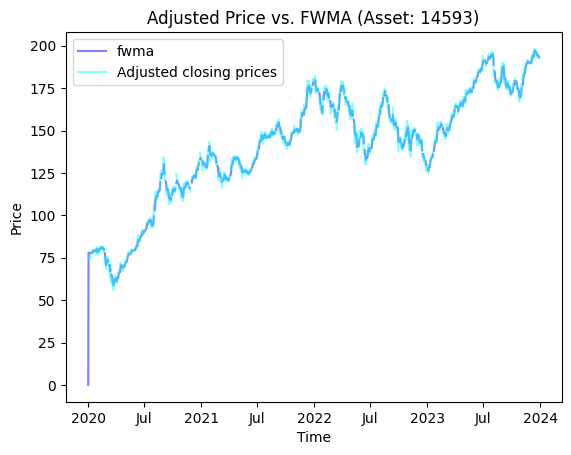

In [24]:
ts['fwma'].plot.line(x="time", label='fwma', color='blue', alpha=0.5) 
ts['close'].plot.line(x="time", label='Adjusted closing prices', color='cyan', alpha=0.5) 
plt.title(f"Adjusted Price vs. FWMA (Asset: {asset_permno})")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(False)

In [25]:
# We will do manual eye-check.

df = ts[['fwma', 'close']].to_dataframe()

df[-20:]['fwma'] # view last 10 records.

time
2023-12-12    194.044342
2023-12-13    195.559601
2023-12-14    196.562515
2023-12-15    196.956436
2023-12-16           NaN
2023-12-17           NaN
2023-12-18    196.574188
2023-12-19    196.721268
2023-12-20    196.006012
2023-12-21    195.505096
2023-12-22    194.768402
2023-12-23           NaN
2023-12-24           NaN
2023-12-25           NaN
2023-12-26    194.110428
2023-12-27    193.745514
2023-12-28    193.669373
2023-12-29    193.221680
2023-12-30           NaN
2023-12-31           NaN
Name: fwma, dtype: float32

In [26]:
# Pandas TA Version

fwma_pd = ta.fwma(df['close'].dropna(), length=10)

fwma_pd[-20:]

time
2023-12-01    190.440489
2023-12-04    190.058319
2023-12-05    191.344962
2023-12-06    191.724057
2023-12-07    192.702660
2023-12-08    193.865948
2023-12-11    193.613776
2023-12-12    194.044338
2023-12-13    195.559585
2023-12-14    196.562520
2023-12-15    196.956438
2023-12-18    196.574198
2023-12-19    196.721261
2023-12-20    196.006016
2023-12-21    195.505103
2023-12-22    194.768393
2023-12-26    194.110422
2023-12-27    193.745523
2023-12-28    193.669371
2023-12-29    193.221678
Name: FWMA_10, dtype: float64

### HMA

In [27]:
INDICATOR_NAME = "hma"

# Create evaluation context with both data and functions
context = {
    "price": "close",
    "window": 10,
    "_dataset": ds_jit
}
context.update(get_function_context())

# JIT compile the evaluation
def _eval(context):
    result = manager.evaluate(INDICATOR_NAME, context)
    return result

result = _eval(context) # eval w/ the context.

asset_permno = 14593 # APPLE's permno
ds = ds.assign(hma=result)

# Select APPLE and the vars we just computed + the closing price.
subset = ds[[INDICATOR_NAME, 'close']].sel(asset=asset_permno) 
ts = subset.dt.to_time_indexed() 

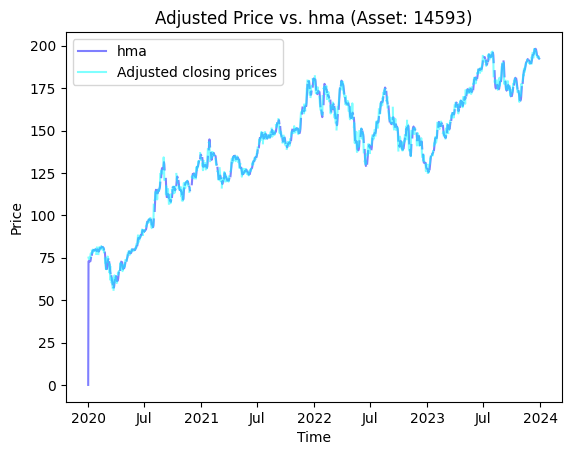

In [28]:
ts[INDICATOR_NAME].plot.line(x="time", label=INDICATOR_NAME, color='blue', alpha=0.5) 
ts['close'].plot.line(x="time", label='Adjusted closing prices', color='cyan', alpha=0.5) 
plt.title(f"Adjusted Price vs. {INDICATOR_NAME} (Asset: {asset_permno})")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(False)

In [29]:
# We will do manual eye-check.

df = ts[[INDICATOR_NAME, 'close']].to_dataframe()

df[-20:][INDICATOR_NAME] # view last 10 records.

time
2023-12-12    195.214737
2023-12-13    196.019562
2023-12-14    197.107483
2023-12-15    197.955353
2023-12-16           NaN
2023-12-17           NaN
2023-12-18    198.033813
2023-12-19    197.824799
2023-12-20    196.918121
2023-12-21    195.831955
2023-12-22    194.637054
2023-12-23           NaN
2023-12-24           NaN
2023-12-25           NaN
2023-12-26    193.599762
2023-12-27    192.839783
2023-12-28    192.601532
2023-12-29    192.451538
2023-12-30           NaN
2023-12-31           NaN
Name: hma, dtype: float32

In [30]:
# Pandas TA Version

hma_pd = ta.hma(df['close'].dropna(), length=10)

hma_pd[-20:]

time
2023-12-01    189.964158
2023-12-04    190.026270
2023-12-05    190.877938
2023-12-06    191.768940
2023-12-07    192.980851
2023-12-08    194.324955
2023-12-11    194.965681
2023-12-12    195.214700
2023-12-13    196.019549
2023-12-14    197.107468
2023-12-15    197.955317
2023-12-18    198.033772
2023-12-19    197.824771
2023-12-20    196.918083
2023-12-21    195.831929
2023-12-22    194.637040
2023-12-26    193.599727
2023-12-27    192.839767
2023-12-28    192.601514
2023-12-29    192.451514
Name: HMA_10, dtype: float64

### HWMA

In [31]:
INDICATOR_NAME = "hwma"

# Create evaluation context with both data and functions
context = {
    "price": "close",
    "window": 10,
    "_dataset": ds_jit,
    "na": 0.2,
    "nb": 0.1,
    "nc": 0.1,
}
context.update(get_function_context())

# JIT compile the evaluation
def _eval(context):
    result = manager.evaluate(INDICATOR_NAME, context)
    return result

result = _eval(context) # eval w/ the context.

asset_permno = 14593 # APPLE's permno
ds = ds.assign(hwma=result)

# Select APPLE and the vars we just computed + the closing price.
subset = ds[[INDICATOR_NAME, 'close']].sel(asset=asset_permno) 
ts = subset.dt.to_time_indexed() 

/home/ubuntu/conda/envs/jax/lib/python3.12/site-packages/jax/_src/core.py:700: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/home/ubuntu/conda/envs/jax/lib/python3.12/site-packages/jax/_src/core.py:700: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/home/ubuntu/conda/envs/jax/lib/python3.12/site-packages/jax/_src/core.py:700: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


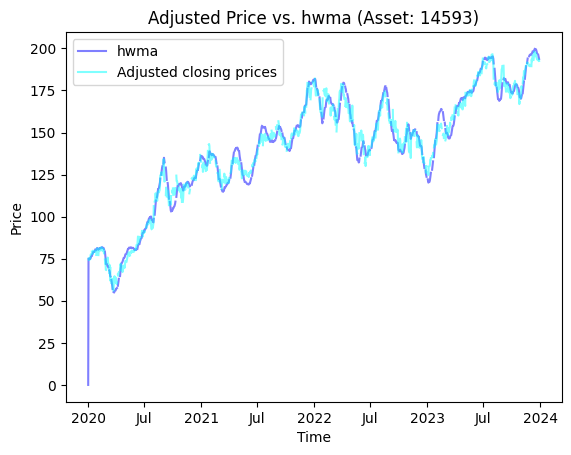

In [32]:
ts[INDICATOR_NAME].plot.line(x="time", label=INDICATOR_NAME, color='blue', alpha=0.5) 
ts['close'].plot.line(x="time", label='Adjusted closing prices', color='cyan', alpha=0.5) 
plt.title(f"Adjusted Price vs. {INDICATOR_NAME} (Asset: {asset_permno})")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(False)

In [33]:
# We will do manual eye-check.

df = ts[[INDICATOR_NAME, 'close']].to_dataframe()

df[-10:][INDICATOR_NAME] # view last 10 records.

time
2023-12-22    197.271637
2023-12-23           NaN
2023-12-24           NaN
2023-12-25           NaN
2023-12-26    196.300552
2023-12-27    195.405518
2023-12-28    194.659546
2023-12-29    193.727356
2023-12-30           NaN
2023-12-31           NaN
Name: hwma, dtype: float32

In [34]:
# Pandas TA Version

hwma_pd = ta.hwma(df['close'].dropna())

hwma_pd[-10:]

time
2023-12-15    199.682587
2023-12-18    199.461243
2023-12-19    199.405899
2023-12-20    198.803604
2023-12-21    198.156784
2023-12-22    197.271652
2023-12-26    196.300568
2023-12-27    195.405533
2023-12-28    194.659561
2023-12-29    193.727356
Name: HWMA_0.2_0.1_0.1, dtype: float32

### KAMA

In [35]:
INDICATOR_NAME = "kama"

# Create evaluation context with both data and functions
context = {
    "price": "close",
    "length": 10,
    "_dataset": ds_jit,
    "fast": 2,
    "slow": 30,
    "drift": 1,
    "fast_sc": (2/(2+1)),
    "slow_sc": (2/(30+1)),
    
}
context.update(get_function_context())

# JIT compile the evaluation
def _eval(context):
    result = manager.evaluate(INDICATOR_NAME, context)
    return result

result = _eval(context) # eval w/ the context.

asset_permno = 14593 # APPLE's permno
ds = ds.assign(kama=result)

# Select APPLE and the vars we just computed + the closing price.
subset = ds[[INDICATOR_NAME, 'close']].sel(asset=asset_permno) 
ts = subset.dt.to_time_indexed() 

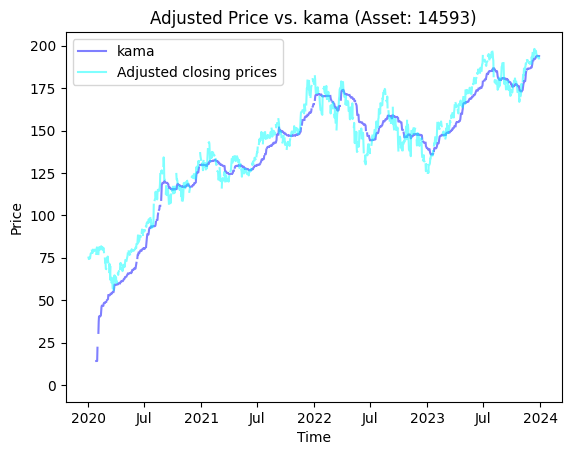

In [36]:
ts[INDICATOR_NAME].plot.line(x="time", label=INDICATOR_NAME, color='blue', alpha=0.5) 
ts['close'].plot.line(x="time", label='Adjusted closing prices', color='cyan', alpha=0.5) 
plt.title(f"Adjusted Price vs. {INDICATOR_NAME} (Asset: {asset_permno})")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(False)

In [37]:
# We will do manual eye-check.

df = ts[[INDICATOR_NAME, 'close']].to_dataframe()

df[-10:][INDICATOR_NAME] # view last 10 records.

time
2023-12-22    193.937515
2023-12-23           NaN
2023-12-24           NaN
2023-12-25           NaN
2023-12-26    193.937515
2023-12-27    193.933685
2023-12-28    193.917068
2023-12-29    193.889984
2023-12-30           NaN
2023-12-31           NaN
Name: kama, dtype: float32

In [38]:
# Pandas TA Version

kama_pd = ta.kama(df['close'].dropna(), length=10, )

kama_pd[-10:]

time
2023-12-15    192.489654
2023-12-18    192.753804
2023-12-19    192.927639
2023-12-20    192.974913
2023-12-21    192.986273
2023-12-22    193.000983
2023-12-26    193.001230
2023-12-27    193.004696
2023-12-28    193.097170
2023-12-29    192.982850
Name: KAMA_10_2_30, dtype: float64

### EMA

In [39]:
from src.data.ast.parser import parse_formula, evaluate_formula
from src.data.ast.functions import get_function_context

# Define the EMA formula as a string
EMA_FORMULA = "ema($price, $window)"
INDICATOR_NAME = "ema"

# Create evaluation context with both data and functions
context = {
    "price": "close",  # This tells the formula to use the 'close' column
    "window": 5,      # 14-period EMA
    "_dataset": ds_jit,  
}

# Add all registered functions to the context
context.update(get_function_context())

# Parse the formula using the vanilla method
ema_ast = parse_formula(EMA_FORMULA)

# Evaluate the parsed formula
result, output_ds = evaluate_formula(ema_ast, context, formula_name="ema")

# The result is your EMA calculation
asset_permno = 14593  # APPLE's permno

# Add the result to your original dataset
ds = ds.assign(ema=result)

# Select APPLE and the vars we just computed + the closing price
subset = ds[["ema", 'close']].sel(asset=asset_permno) 
ts = subset.dt.to_time_indexed()

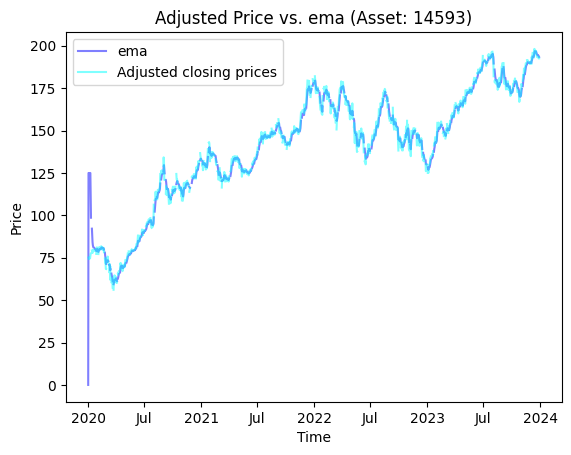

In [40]:
ts[INDICATOR_NAME].plot.line(x="time", label=INDICATOR_NAME, color='blue', alpha=0.5) 
ts['close'].plot.line(x="time", label='Adjusted closing prices', color='cyan', alpha=0.5) 
plt.title(f"Adjusted Price vs. {INDICATOR_NAME} (Asset: {asset_permno})")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(False)

In [41]:
# We will do manual eye-check.

df = ts[[INDICATOR_NAME, 'close']].to_dataframe()

df[-30:][INDICATOR_NAME] # view last 10 records.

time
2023-12-02           NaN
2023-12-03           NaN
2023-12-04    190.043198
2023-12-05    191.168793
2023-12-06    191.552536
2023-12-07    192.458359
2023-12-08    193.542236
2023-12-09           NaN
2023-12-10           NaN
2023-12-11    193.421494
2023-12-12    193.850998
2023-12-13    195.220673
2023-12-14    196.183792
2023-12-15    196.645874
2023-12-16           NaN
2023-12-17           NaN
2023-12-18    196.393921
2023-12-19    196.575958
2023-12-20    195.993973
2023-12-21    195.555984
2023-12-22    194.904007
2023-12-23           NaN
2023-12-24           NaN
2023-12-25           NaN
2023-12-26    194.286011
2023-12-27    193.907349
2023-12-28    193.798248
2023-12-29    193.375504
2023-12-30           NaN
2023-12-31           NaN
Name: ema, dtype: float32

In [42]:
# Pandas TA Version

ema_pd = ta.ema(df['close'].dropna(), length=5)

ema_pd[-30:]

time
2023-11-16    187.089759
2023-11-17    187.956507
2023-11-20    189.121004
2023-11-21    189.627336
2023-11-22    190.188223
2023-11-24    190.115482
2023-11-27    190.006986
2023-11-28    190.137989
2023-11-29    189.881991
2023-11-30    189.904660
2023-12-01    190.349775
2023-12-04    190.043181
2023-12-05    191.168787
2023-12-06    191.552527
2023-12-07    192.458353
2023-12-08    193.542237
2023-12-11    193.421489
2023-12-12    193.850995
2023-12-13    195.220666
2023-12-14    196.183777
2023-12-15    196.645854
2023-12-18    196.393902
2023-12-19    196.575936
2023-12-20    195.993958
2023-12-21    195.555969
2023-12-22    194.903982
2023-12-26    194.285989
2023-12-27    193.907324
2023-12-28    193.798216
2023-12-29    193.375477
Name: EMA_5, dtype: float64